# Face Recognition using ORL Dataset and PCA

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import cycle

## 1. Load and Prepare Dataset

In [93]:
# ORL dataset path
data_dir = r"Training_data"

# Function to load ORL dataset
def load_orl_faces(data_dir):
    faces = []
    labels = []
    
    # Loop through each person (s1, s2, ..., s40)
    for person_id in range(1, 41):
        person_dir = os.path.join(data_dir, f's{person_id}')
        
        # Check if directory exists
        if not os.path.isdir(person_dir):
            continue
            
        # Loop through each image (1.pgm, 2.pgm, ..., 10.pgm)
        for image_id in range(1, 11):
            image_path = os.path.join(person_dir, f'{image_id}.pgm')
            
            # Check if image exists
            if not os.path.exists(image_path):
                continue
                
            # Open image, convert to numpy array, and flatten
            img = Image.open(image_path)
            img_array = np.array(img).flatten()
            
            # Add to data lists
            faces.append(img_array)
            labels.append(person_id - 1)  # 0-indexed labels
    
    return np.array(faces), np.array(labels)

# Load the dataset
X, y = load_orl_faces(data_dir)
print(f"Dataset loaded: {X.shape[0]} images, {X.shape[1]} features per image")
print(f"Number of subjects: {len(np.unique(y))}")

Dataset loaded: 394 images, 10304 features per image
Number of subjects: 40


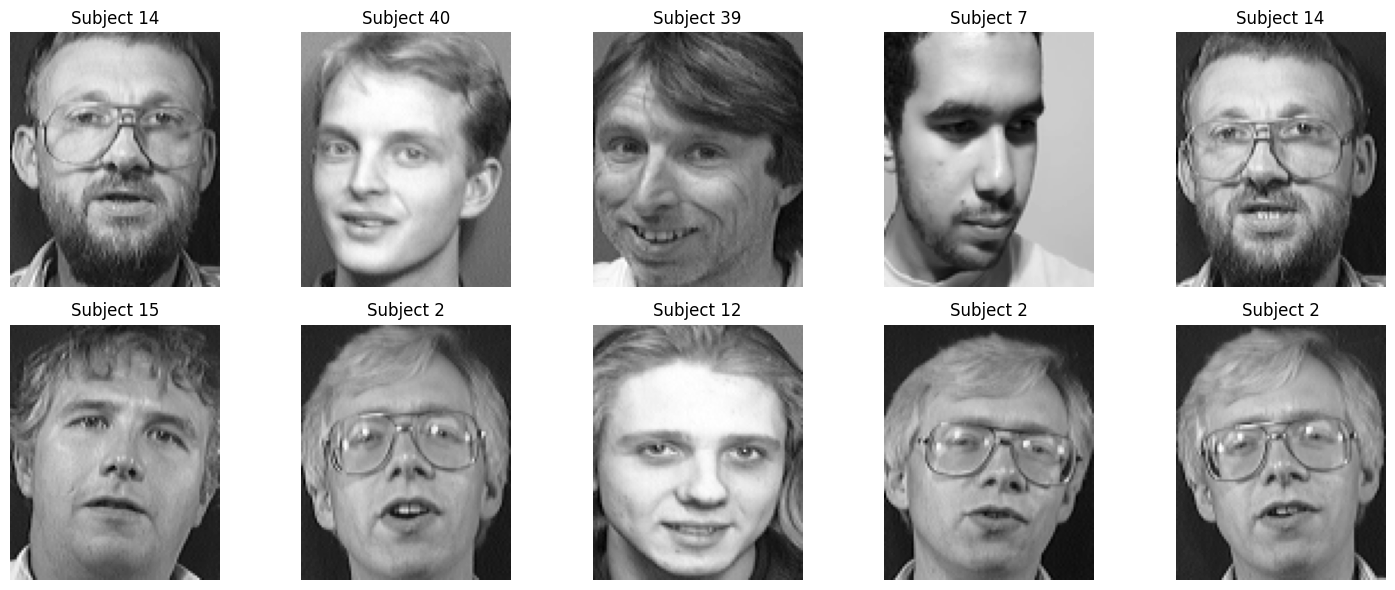

In [73]:
# Visualize a few face examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    # Get a random index
    idx = np.random.randint(0, X.shape[0])
    
    # Reshape the flattened image back to 2D (assuming 112x92 images)
    face = X[idx].reshape(112, 92)
    
    # Display image
    axes[i].imshow(face, cmap='gray')
    axes[i].set_title(f"Subject {y[idx]+1}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## 2. Split Data into Training and Test Sets

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 275 images
Testing set size: 119 images


## 3. Standardize Data

Standardizing the data is important before applying PCA.

In [96]:
# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Apply PCA for Dimensionality Reduction

In [97]:
# Create a custom PCA implementation from scratch
class CustomPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None
        
    def fit_transform(self, X):
        # Store the mean
        self.mean_ = np.mean(X, axis=0)
        
        # Center the data
        X_centered = X - self.mean_
        
        # Calculate the covariance matrix
        n_samples = X_centered.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        
        # Compute eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in decreasing order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Calculate explained variance ratio
        total_var = np.sum(eigenvalues)
        self.explained_variance_ = eigenvalues
        self.explained_variance_ratio_ = eigenvalues / total_var
        
        # Determine number of components based on input
        if isinstance(self.n_components, float) and self.n_components < 1:
            cumulative_variance = np.cumsum(self.explained_variance_ratio_)
            self.n_components = np.argmax(cumulative_variance >= self.n_components) + 1
        
        # Select top k eigenvectors
        self.components_ = eigenvectors[:, :self.n_components].T
        
        # Project the data
        return np.dot(X_centered, eigenvectors[:, :self.n_components])
    
    def transform(self, X):
        # Center the data using the mean from the training data
        X_centered = X - self.mean_
        
        # Project the centered data
        return np.dot(X_centered, self.components_.T)

# Use our custom PCA implementation
custom_pca = CustomPCA(n_components=0.90)
X_train_pca = custom_pca.fit_transform(X_train_scaled)
X_test_pca = custom_pca.transform(X_test_scaled)

print(f"Original dimensionality: {X_train.shape[1]}")
print(f"Reduced dimensionality: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {sum(custom_pca.explained_variance_ratio_[:custom_pca.n_components]):.4f}")

Original dimensionality: 10304
Reduced dimensionality: 91
Explained variance ratio: 0.9003


Displaying 91 eigenfaces


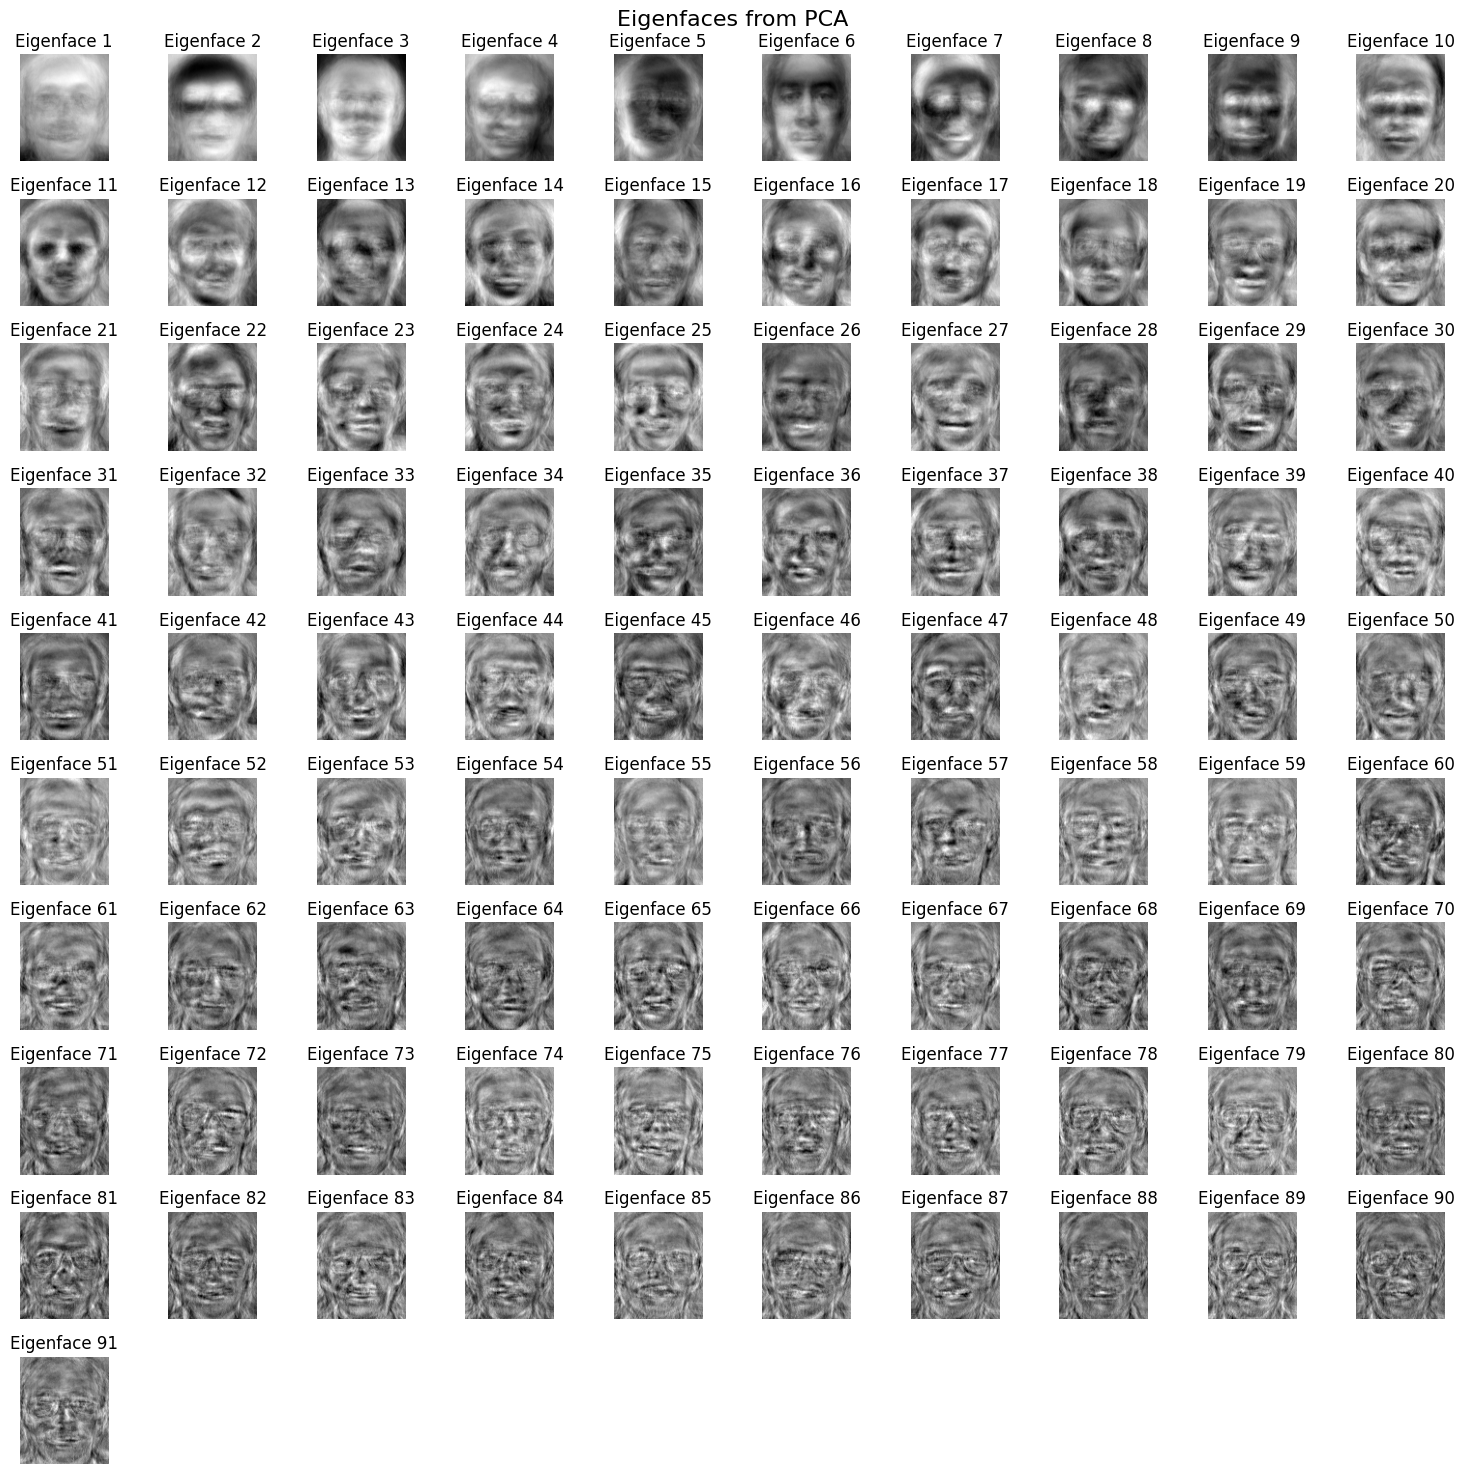

In [99]:
# Get the number of components from custom PCA
n_components = custom_pca.n_components
print(f"Displaying {n_components} eigenfaces")

# Calculate the grid size needed
grid_size = int(np.ceil(np.sqrt(n_components)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i in range(min(n_components, len(axes))):
    eigenface = custom_pca.components_[i].reshape(112, 92)
    
    # Display image
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].set_title(f"Eigenface {i+1}")
    axes[i].axis('off')

# Turn off axes for unused subplots
for i in range(min(n_components, len(axes)), len(axes)):
    axes[i].axis('off')
    
plt.suptitle("Eigenfaces from PCA", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## 5. Train a Classifier

We'll use a Support Vector Machine (SVM) classifier, which works well with PCA features.

In [100]:
classifier = SVC(kernel='rbf', gamma='scale')
classifier.fit(X_train_pca, y_train)

SVC()

## 6.1 Evaluate the Model

In [101]:

y_pred = classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.60      1.00      0.75         3
          16       1.00      1.00      1.0

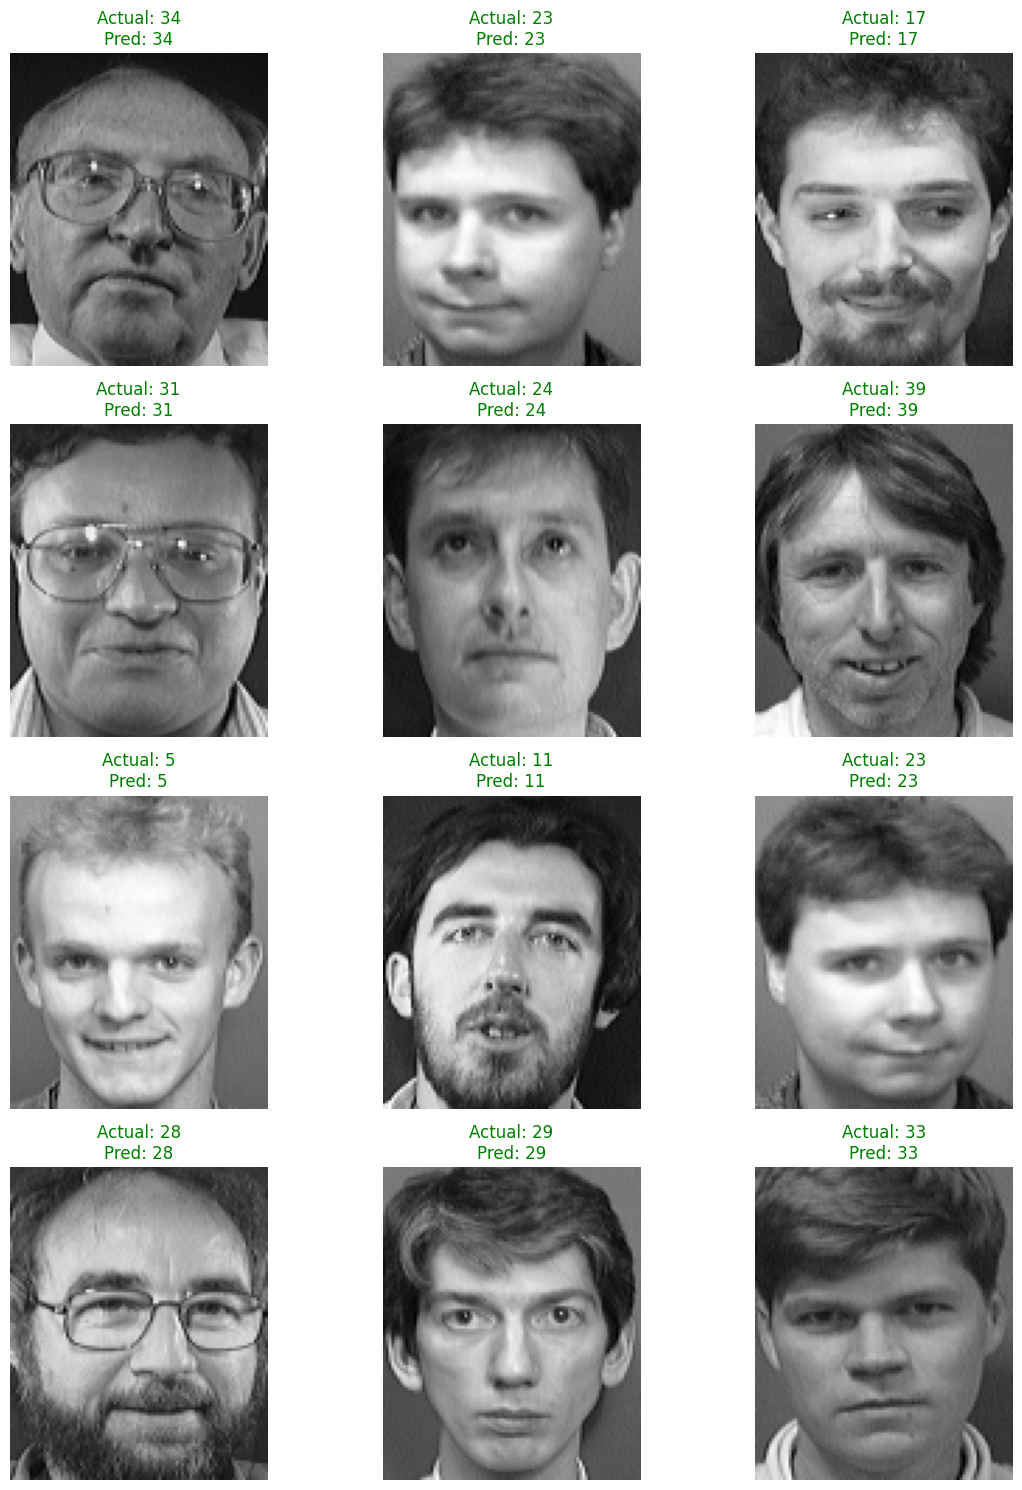

In [102]:
# Visualize some predictions
fig, axes = plt.subplots(4, 3, figsize=(12, 15))
axes = axes.flatten()

# Get some random test samples
indices = np.random.choice(range(len(X_test)), 12, replace=False)

for i, idx in enumerate(indices):
    # Reshape the flattened image back to 2D (assuming 112x92 images)
    face = X_test[idx].reshape(112, 92)
    
    # Display image
    axes[i].imshow(face, cmap='gray')
    correct = y_test[idx] == y_pred[idx]
    color = 'green' if correct else 'red'
    axes[i].set_title(f"Actual: {y_test[idx]+1}\nPred: {y_pred[idx]+1}", color=color)
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## 6.2 ROC Curve Analysis

ROC (Receiver Operating Characteristic) curves are a useful tool for evaluating classifier performance, especially for multi-class problems. We'll create ROC curves using a one-vs-rest approach for each class.

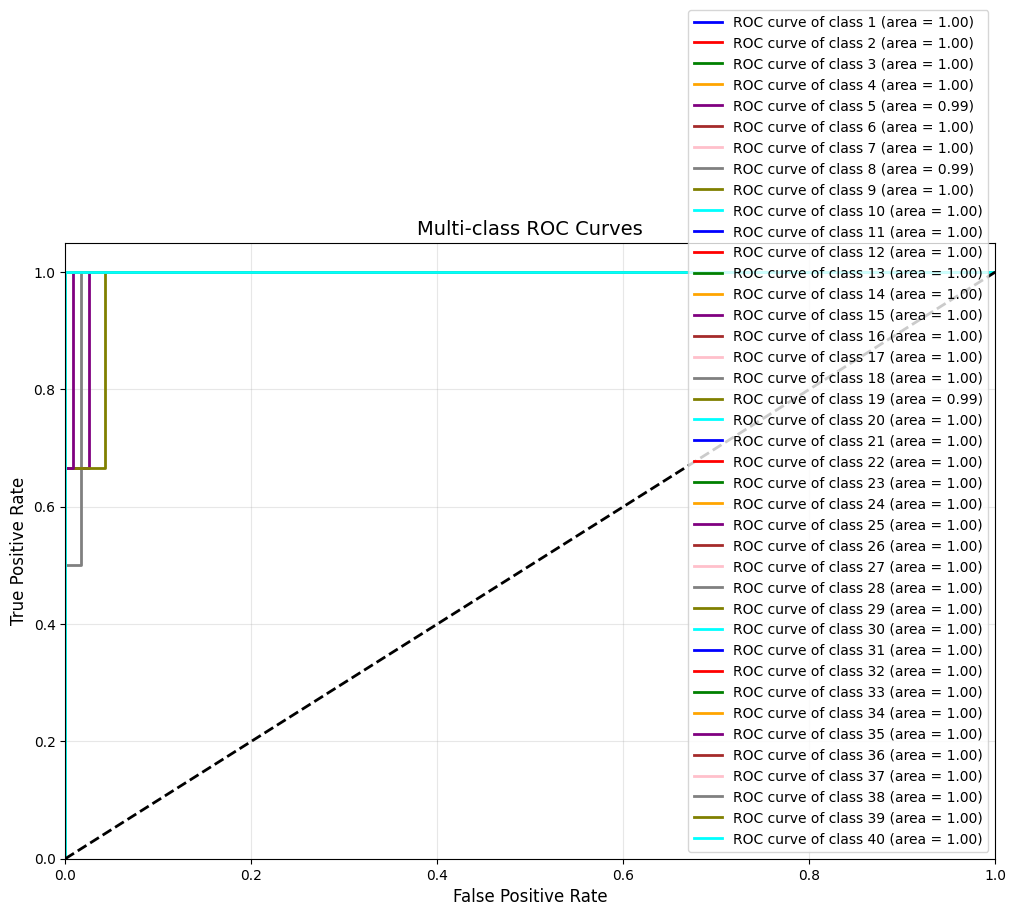

In [103]:
# Binarize the output labels for ROC curve calculation
classes = np.unique(y)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# We need decision function values for ROC curves
# For SVM, we can use decision_function method
decision_values = classifier.decision_function(X_test_pca)


# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # For multi-class problems, decision_values[:, i] gives the confidence score for class i
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], decision_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curves', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 7. Experiment with Different PCA Components

Let's see how the number of principal components affects accuracy.

In [104]:
n_components_list = [5, 10, 15, 20, 25, 30 , 40, 50, 60, 70, 80, 90]  
accuracies = []

for n_components in n_components_list:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Train classifier
    classifier = SVC(kernel='rbf', gamma='scale')
    classifier.fit(X_train_pca, y_train)
    
    # Evaluate
    y_pred = classifier.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    print(f"Components: {n_components}, Accuracy: {accuracy:.4f}, Variance Explained: {sum(pca.explained_variance_ratio_):.4f}")

Components: 5, Accuracy: 0.7059, Variance Explained: 0.4561
Components: 10, Accuracy: 0.9160, Variance Explained: 0.5866
Components: 15, Accuracy: 0.9160, Variance Explained: 0.6522
Components: 20, Accuracy: 0.9412, Variance Explained: 0.6976
Components: 25, Accuracy: 0.9496, Variance Explained: 0.7302
Components: 30, Accuracy: 0.9496, Variance Explained: 0.7563
Components: 40, Accuracy: 0.9496, Variance Explained: 0.7976
Components: 50, Accuracy: 0.9496, Variance Explained: 0.8273
Components: 60, Accuracy: 0.9496, Variance Explained: 0.8504
Components: 70, Accuracy: 0.9496, Variance Explained: 0.8692
Components: 80, Accuracy: 0.9496, Variance Explained: 0.8849
Components: 90, Accuracy: 0.9496, Variance Explained: 0.8983


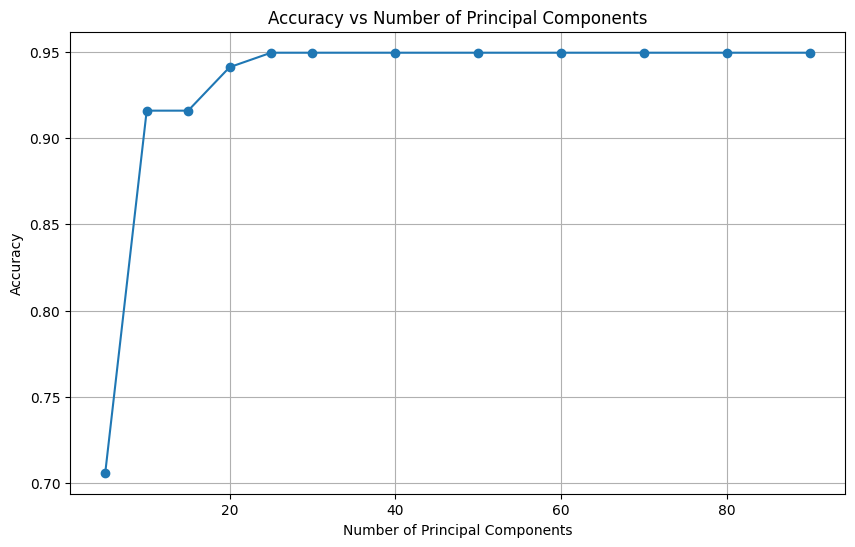

In [105]:
# Plot accuracy vs number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, accuracies, marker='o')
plt.grid(True)
plt.title('Accuracy vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

In [106]:
import joblib

# Create a directory for saved models if it doesn't exist
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')

# Save the trained model, PCA transformer, and scaler
joblib.dump(classifier, 'saved_model/svm_classifier.pkl')
joblib.dump(pca, 'saved_model/pca_model.pkl')
joblib.dump(scaler, 'saved_model/scaler.pkl')

print("Model and preprocessing components saved successfully!")

Model and preprocessing components saved successfully!
